# Introdução

Uma das partes principais do trabalho de um Cientista de Dados consiste na análise exploratória e limpeza de dados. Para exercitar tal característica, utilizei da base de dados, disponibilizada pela empresa Airbnb, que contém informações de quartos no estado do Rio de Janeiro.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import folium
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [3]:
anuncios = pd.read_csv('/content/drive/MyDrive/CIS_1Periodo-main/anuncios_airbnb.csv')
anuncios.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,17878,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",68997,Matthias,NaN,Copacabana,-22.96599,-43.17940,Entire home/apt,350,5,288,2023-03-01,1.86,1,264,19,NaN
1,24480,"Nice and cozy near Ipanema Beach, w/ home office",99249,Goya,NaN,Ipanema,-22.98405,-43.20189,Entire home/apt,624,3,86,2023-03-27,0.56,3,357,1,NaN
2,200568,30m of Ipa Beach e fins de semana special price !,980805,Henrique,NaN,Ipanema,-22.98586,-43.19411,Entire home/apt,100,30,198,2023-02-13,1.45,6,59,9,NaN
3,342874,Comfortable in Copacabana beach,829630,Luciana,NaN,Leme,-22.96392,-43.17263,Entire home/apt,236,2,159,2023-02-26,1.19,3,105,31,NaN
4,25026,Beautiful Modern Decorated Studio in Copa,102840,Viviane,NaN,Copacabana,-22.97735,-43.19105,Entire home/apt,307,3,262,2023-03-27,1.68,1,257,14,NaN


# Limpeza dos dados

Antes de realizar uma análise, é necessário limpar nossa base de dados

In [4]:
#Removendo colunas que não serão utilizadas em nosso projeto, afim de diminuir a quantidade de dados presente do database
anuncios.drop(columns=['name', 'host_name', 'id', 'host_id', 'neighbourhood_group', 'last_review', 'license'], inplace=True)
anuncios.to_excel('anuncios_airbnb.xlsx') #Transformando o arquivo csv em excel, devido a erros na leitura do arquivo

In [5]:
#Vamos tentar obter algumas informações gerais dos nossos dados para que possamos limpar adequadamente
anuncios.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,30476.000000,30476.000000,30476.000000,30476.000000,30476.000000,22972.000000,30476.000000,30476.000000,30476.000000
mean,-22.967200,-43.250334,981.616912,4.854312,18.260172,1.014667,9.816118,210.453865,6.631940
std,0.035228,0.099710,8625.188625,24.354187,38.502717,1.082735,28.249902,136.075327,10.830069
min,-23.073276,-43.701286,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,-22.984780,-43.308549,200.000000,1.000000,1.000000,0.230000,1.000000,85.000000,0.000000
50%,-22.972620,-43.195535,350.000000,2.000000,4.000000,0.700000,2.000000,212.000000,2.000000
75%,-22.954726,-43.185841,650.000000,4.000000,17.000000,1.440000,4.000000,359.000000,8.000000
max,-22.749690,-43.104400,595793.000000,1125.000000,588.000000,17.010000,224.000000,365.000000,146.000000


## Obervações



*   75% dos valores de "minimum_nigths" são abaixo de quatro noites e possui valor máximo 1125 noites
*   O valor máximo que alguém pode pagar por um airbnb é R$595.793,00 (algo bastante discrepante da realidade brasileira e dos nossos dados)



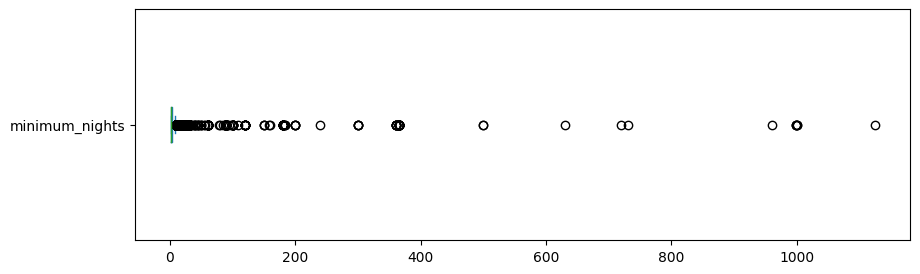

In [6]:
#Vamos plotar um gráfico para verificar como as informações de 'minimum_nights' estão distribuidas
anuncios.minimum_nights.plot(kind='box', vert=False, figsize=(10,3))

#Remover situações em que o 'minimum_nights' é maior que 30 dias (1 mês)
anuncios.drop(anuncios[anuncios.minimum_nights > 30].index, axis=0, inplace=True)

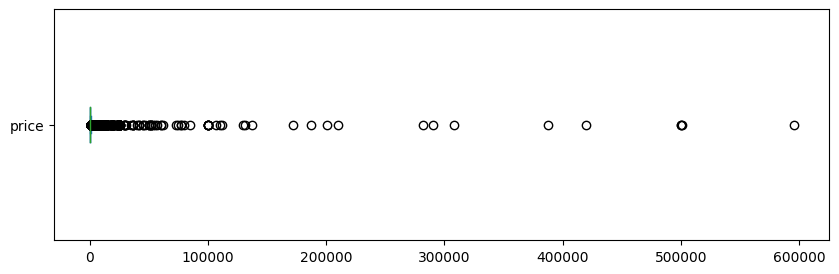

In [7]:
##Vamos plotar um gráfico para verificar como as informações de 'price' estão distribuidas
anuncios.price.plot(kind='box', vert=False, figsize=(10,3))

#Removeção de casos em que o valor de 'price' for maior que R$3.000,00 (um pouco mais de 3 vezes o desvio padrão)
anuncios.drop(anuncios[anuncios.price > 3000].index, axis=0, inplace=True)

## Buscando valores vazios

In [8]:
print('Quantidade de informações vazias em cada coluna:')
print(anuncios.isnull().sum())

Quantidade de informações vazias em cada coluna:
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 6739
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
dtype: int64


Visto que há apenas uma coluna com dados faltantes, iremos removê-lá e trabalharemos com outras informações.

In [9]:
anuncios.drop(columns=['reviews_per_month'], inplace=True)

# Análise exploratória

Para uma análise inicial, vamos buscar entender como nossos dados estariam organizados espacialmente (de acordo com latitude e longitude)

<Axes: xlabel='longitude', ylabel='latitude'>

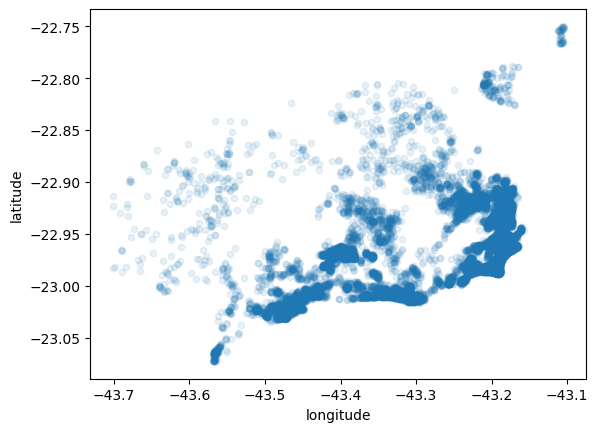

In [10]:
#Plotagem inicial de um gráfico de pontos de latitude e longitude
anuncios.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<Axes: xlabel='longitude', ylabel='latitude'>

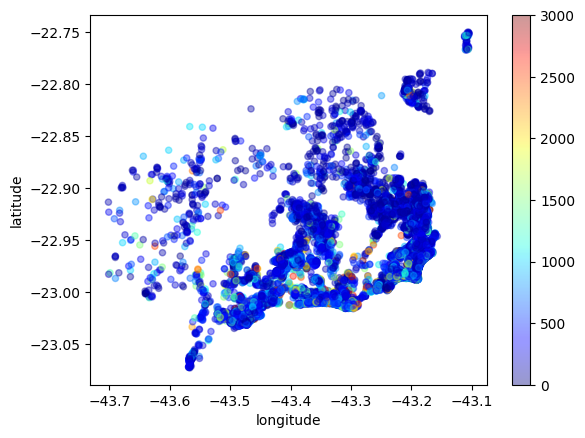

In [11]:
#Plotagem de um gráfico de longitude x latitude com variação de cor de acordo com a variação de preços de aluguel
anuncios.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, c=anuncios['price'], cmap=plt.get_cmap('jet'))

Com isso, oberva-se que não há uma variação de preços de acordo com o localização, de maneira que é possível encontrar alugueis baratos bem próximos de alugueis mais caros.

Vamos investigar mais.

In [12]:
correlacao = anuncios.corr()
correlacao['price'].sort_values(ascending=False)

<ipython-input-12-5ff42ab7ca23>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacao = anuncios.corr()


price                             1.000000
availability_365                  0.118831
minimum_nights                    0.105359
calculated_host_listings_count    0.081121
longitude                        -0.095786
number_of_reviews                -0.152274
latitude                         -0.196644
number_of_reviews_ltm            -0.203385
Name: price, dtype: float64

Observa-se, na tabela a cima, que há pouca correlação entre a variável preço e as demais variáveis numéricas.

A seguir, vamos investigar como elas podem estar relacionadas as variáveis categóricas.

In [13]:
print(anuncios['room_type'].value_counts())

Entire home/apt    22673
Private room        6062
Shared room          492
Hotel room            47
Name: room_type, dtype: int64


Há muita oferta de aluguéis de casas/apartamentos inteiros na cidade do Rio de Janeiro

In [14]:
print(anuncios.groupby('room_type')['price'].mean())

room_type
Entire home/apt    559.477705
Hotel room         432.000000
Private room       307.699769
Shared room        182.335366
Name: price, dtype: float64


Assim, ao visitar o Rio de Janeiro, caso se deseja alugar um Airbnb pode se esperar que quartos compartilhados sejam, em média, os mais baratos como também os que possuem mais opções

Para verificar quais regiões possuem o preço médio mais caro, vamos criar um gráfico de barras simples

In [15]:
preco_medio_bairro = anuncios.groupby('neighbourhood')['price'].mean().reset_index()
top_10_bairros = preco_medio_bairro.nlargest(10, 'price')

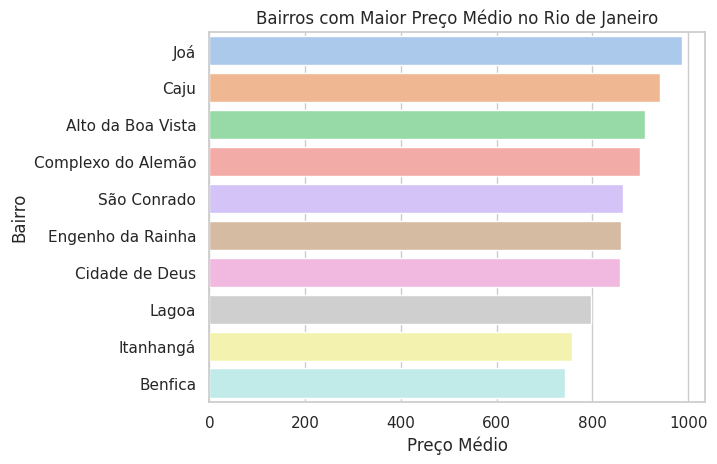

In [16]:
# Configurações estéticas do Seaborn
sb.set(style="whitegrid")
pastel_palette = sb.color_palette("pastel")
sb.set_palette(pastel_palette)

# Criar o gráfico
sb.barplot(x='price', y='neighbourhood', data=top_10_bairros, orient='h')
plt.xlabel('Preço Médio')
plt.ylabel('Bairro')
plt.title('Bairros com Maior Preço Médio no Rio de Janeiro')
plt.show()

Caso se deseje visualizar o preço médio de todos os bairros do Rio de Janeiro, utilize o mapa iterativo abaixo

In [18]:
# Criar um mapa centrado no Rio de Janeiro
rio_map = folium.Map(location=[-22.9068, -43.1729], zoom_start=12)

# Adicionar marcadores para cada bairro com informações de preço médio
for index, row in preco_medio_bairro.iterrows():
    bairro = row['neighbourhood']
    preço_medio = row['price']

    # Verificar se o bairro está entre os 10 com maior preço
    if bairro in top_10_bairros['neighbourhood'].values:
        icone = folium.Icon(color='red', icon='info-sign')  # Ícone vermelho para os top 10
    else:
        icone = folium.Icon(color='blue')  # Ícone azul para os outros

    popup_text = f"Bairro: {bairro}<br>Preço Médio: R$ {preço_medio:.2f}"
    folium.Marker(location=(anuncios[anuncios['neighbourhood'] == bairro]['latitude'].iloc[0],
                  anuncios[anuncios['neighbourhood'] == bairro]['longitude'].iloc[0]),
                  popup=popup_text,
                  icon=icone).add_to(rio_map)

# Exibir o mapa na tela
display(rio_map)

Com isso em mente, vamos buscar entender a opinião dos clientes contratantes e onde eles costumam se hospedar com mais frequência se encontram os airbnb mais bem avaliados.

In [33]:
avaliacao_media_bairro = anuncios.groupby('neighbourhood')['availability_365'].mean()
top_5_bairros = avaliacao_media_bairro.nsmallest(5)
print("Bairros com menor disponibilidade média ao longo do ano:")
print('')
for bairro, qtnd_media in top_5_bairros.items():
    print(f"{bairro}: {qtnd_media:.0f} dias disponiveis, em média")

Bairros com menor disponibilidade média ao longo do ano:

Acari: 0 dias disponiveis, em média
Magalhães Bastos: 0 dias disponiveis, em média
Manguinhos: 0 dias disponiveis, em média
Abolição: 86 dias disponiveis, em média
Engenheiro Leal: 89 dias disponiveis, em média


# Conclusão

De acordo com os dados explorados, observa-se que não há uma extratificação de preço por região na cidade do Rio de Janeiro, ou seja, é possível encontrar quartos ou apartamentos por preços acessíveis e preços luxuosos em várias localidades.

Apesar disso, apartamentos inteiros costumam ter os preços mais elevados em comparação com as demais categorias e em média, os alugueis são realizados para 5 dias.

Em conjunto a isso, bairros como Acari, Magalhães Bastos e Manguinhos se demonstram como os preferidos dos usuários da plataforma. Destes três, nenhum esteve entre o TOP 10 dos maiores preços para aluguel.

Tendo em vista a baixa correlação entre todas as variáves númericas, optamos por não utilizar técnicas de machine learning para realizar predições